In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes = True)
from sklearn.preprocessing import StandardScaler, LabelEncoder,  MinMaxScaler
!pip install category_encoders
import category_encoders as ce
from sklearn.feature_selection import VarianceThreshold
from ast import increment_lineno
import io
import math
from google.colab import files
uploaded = files.upload()


Saving MagicBricks.csv to MagicBricks (1).csv


In [16]:
import os
print(os.getcwd())

/content


In [37]:
df = pd.read_csv("MagicBricks.csv")

In [38]:
print("Original data shape: ")
df.shape

Original data shape: 


(1259, 11)

In [39]:
df.head()

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,NaN
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment,6667.0
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment,6667.0
3,600.0,2,2.0,Semi-Furnished,Rohini Sector 24,1.0,4200000,Ready_to_move,Resale,Builder_Floor,6667.0
4,650.0,2,2.0,Semi-Furnished,Rohini Sector 24 carpet area 650 sqft status R...,1.0,6200000,Ready_to_move,New_Property,Builder_Floor,6667.0


In [40]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Area         1259 non-null   float64
 1   BHK          1259 non-null   int64  
 2   Bathroom     1257 non-null   float64
 3   Furnishing   1254 non-null   object 
 4   Locality     1259 non-null   object 
 5   Parking      1226 non-null   float64
 6   Price        1259 non-null   int64  
 7   Status       1259 non-null   object 
 8   Transaction  1259 non-null   object 
 9   Type         1254 non-null   object 
 10  Per_Sqft     1018 non-null   float64
dtypes: float64(4), int64(2), object(5)
memory usage: 108.3+ KB
None
               Area          BHK     Bathroom      Parking         Price  \
count   1259.000000  1259.000000  1257.000000  1226.000000  1.259000e+03   
mean    1466.452724     2.796664     2.556086     1.935563  2.130670e+07   
std     1568.055040     0.954425     1.042220     

In [41]:
# Remove duplicates
duplicat_rows_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicat_rows_df.shape)
initial_count = len(df)
df = df.drop_duplicates()
print("Removed duplicate rows: ")
initial_count - len(df)


number of duplicate rows:  (83, 11)
Removed duplicate rows: 


83

In [42]:
# Handle missing values

missing_before = df.isnull().sum()
print("Before handling missing values:")
print(missing_before)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.median()))

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if not df[col].mode().empty:
        df[col] = df[col].fillna(df[col].mode()[0])

missing_after = df.isnull().sum()
print("\nAfter handling missing values:")
print(missing_after)


Before handling missing values:
Area             0
BHK              0
Bathroom         1
Furnishing       5
Locality         0
Parking         31
Price            0
Status           0
Transaction      0
Type             5
Per_Sqft       227
dtype: int64

After handling missing values:
Area           0
BHK            0
Bathroom       0
Furnishing     0
Locality       0
Parking        0
Price          0
Status         0
Transaction    0
Type           0
Per_Sqft       0
dtype: int64


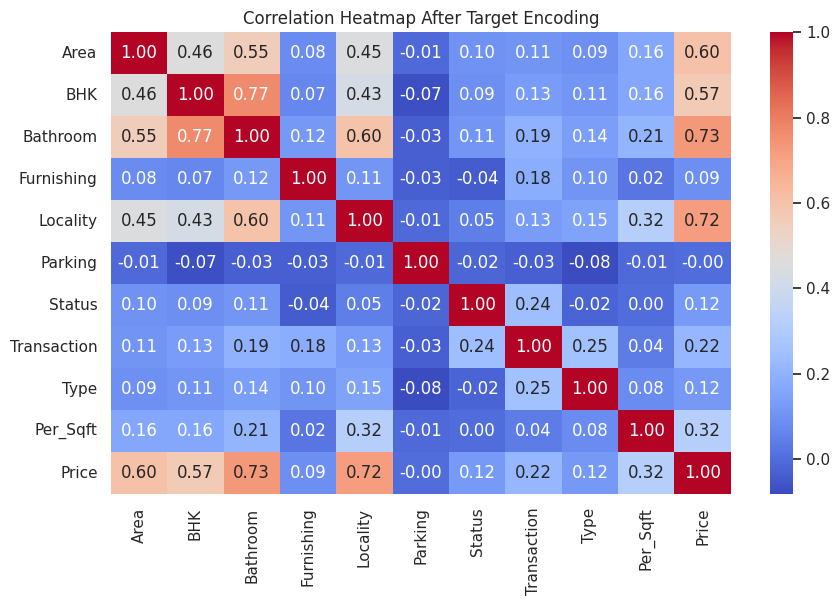

In [43]:
# Target Encoding
target = "Price"
y = df[target]
X = df.drop(columns=[target])

encoder = ce.TargetEncoder(cols=X.select_dtypes(include=['object']).columns)
X_encoded = encoder.fit_transform(X, y)

df = pd.concat([X_encoded, y], axis=1)

corr = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap After Target Encoding")
plt.show()

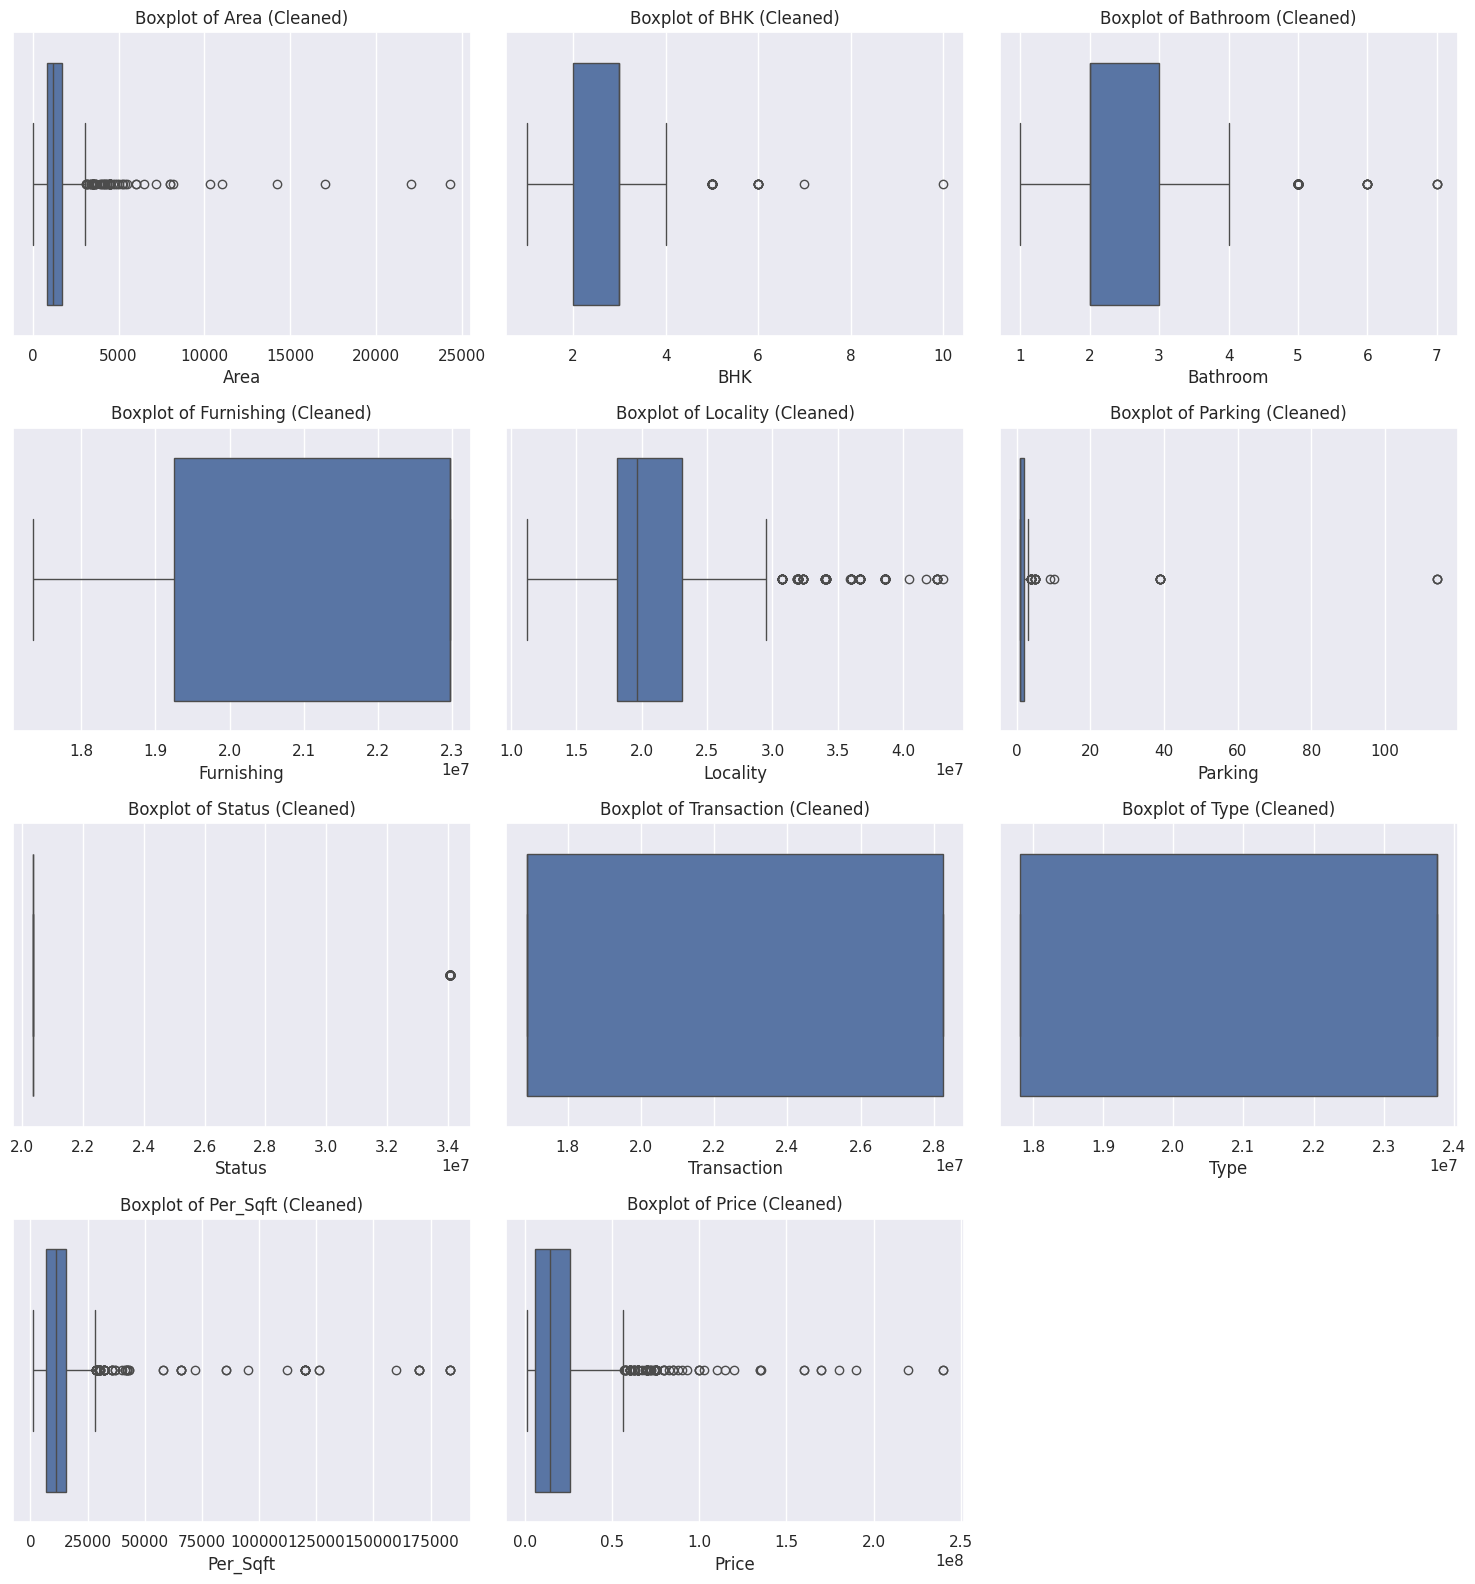

In [44]:
# Remove outliers using IQR
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

df_clean = df.copy()

for col in ['Area', 'Bathroom', 'Parking', 'Price', 'Per_Sqft']:
    if col in df_clean.columns:
        df_clean = remove_outliers_iqr(df_clean, col)

df_clean = df_clean.reset_index(drop=True)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
n = len(num_cols)

rows = math.ceil(n / 3)
cols = 3

plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col} (Cleaned)")

plt.tight_layout()
plt.show()

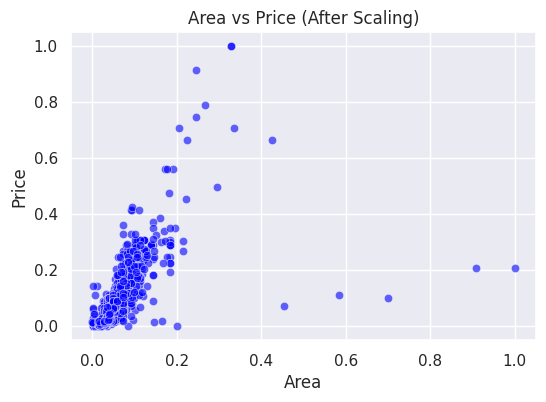

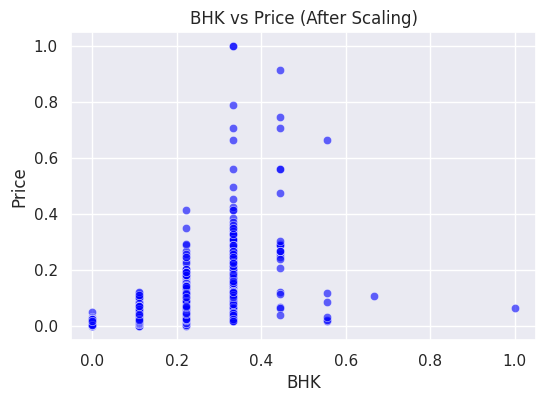

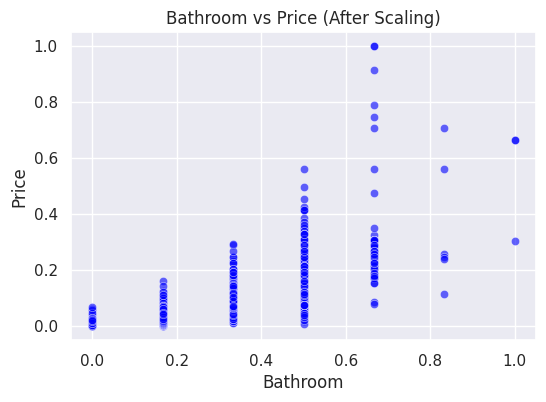

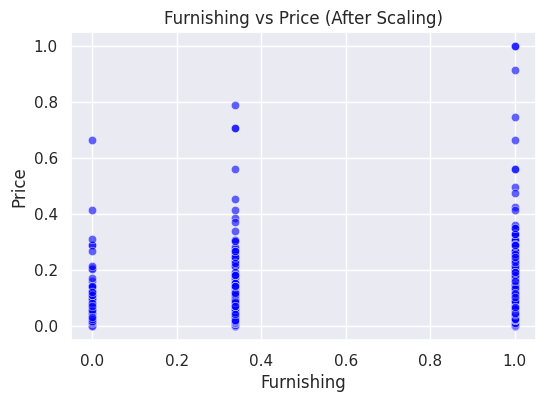

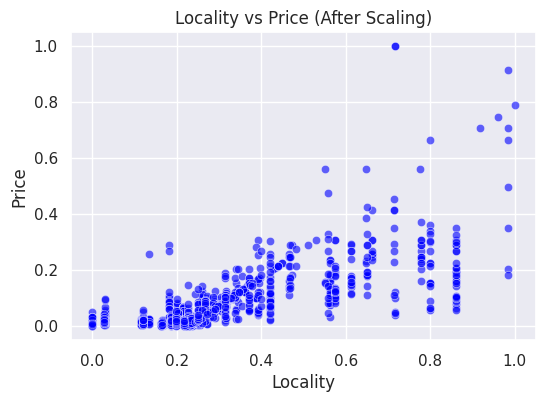

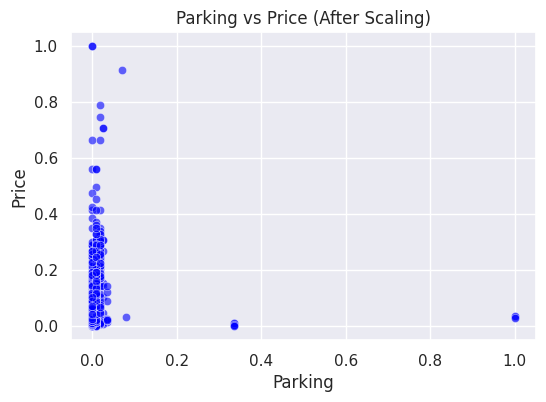

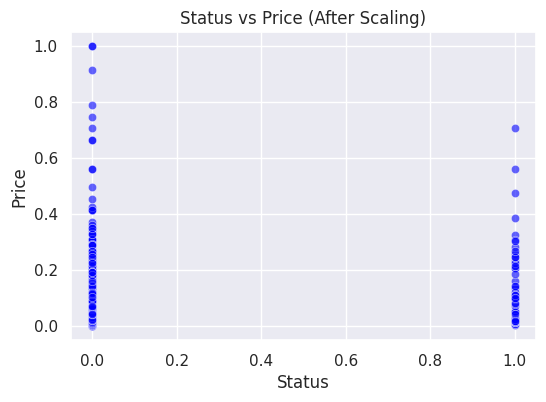

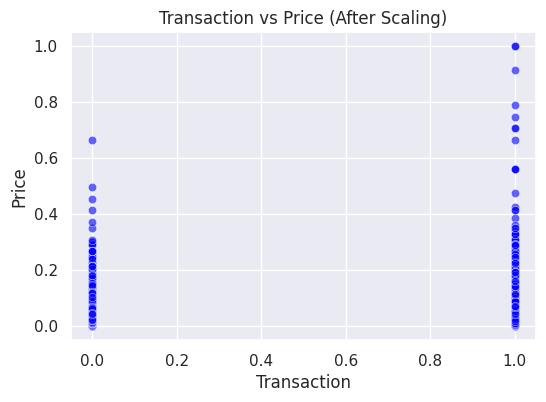

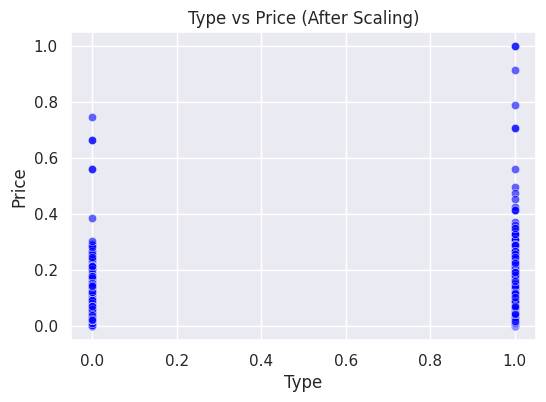

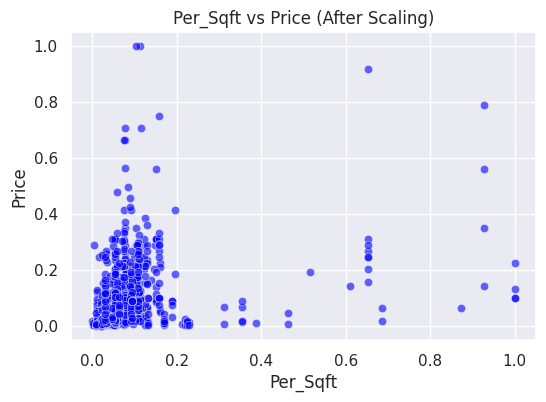

In [45]:
# MinMax Scaling
scaler = MinMaxScaler()

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

df[num_cols] = scaler.fit_transform(df[num_cols])

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

target = "Price"

for col in num_cols:
    if col != target:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col], y=df[target], color="blue", alpha=0.6)
        plt.title(f"{col} vs {target} (After Scaling)")
        plt.xlabel(col)
        plt.ylabel(target)
        plt.show()

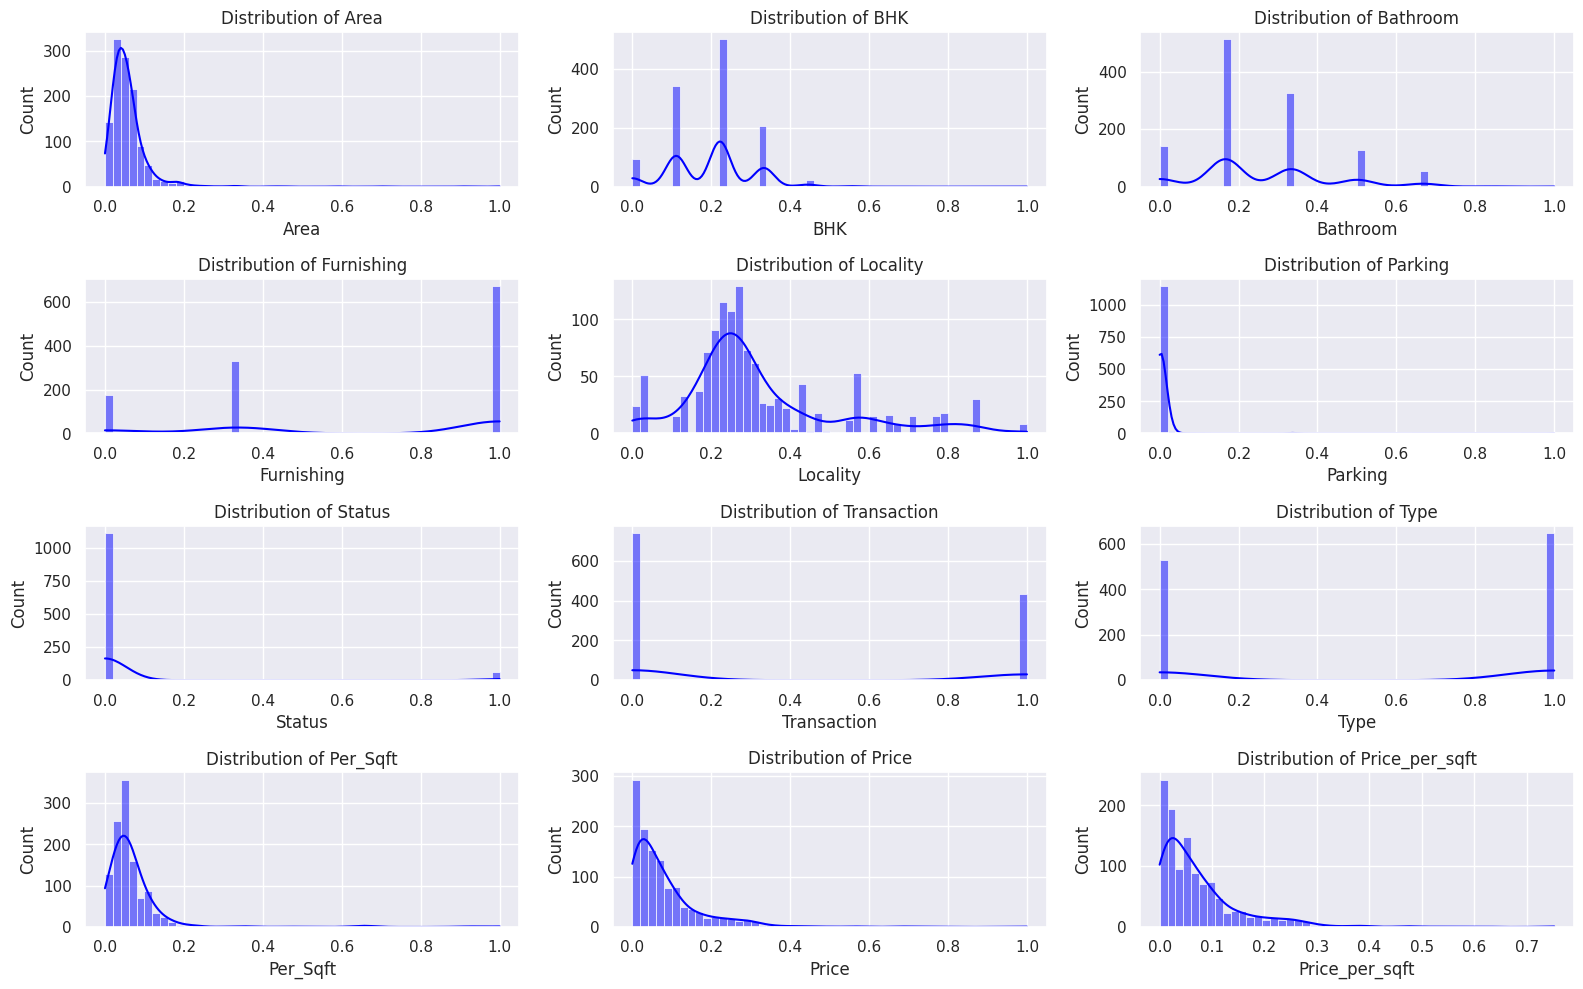

In [46]:
# 5. Add new feature
if "Area" in df.columns and "Price" in df.columns:
    df["Price_per_sqft"] = df["Price"] / (df["Area"] + 1)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(16, 12))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.histplot(df[col], bins=50, kde=True, color="blue")
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

Reduced dataset saved as IT24100637_Final.csv


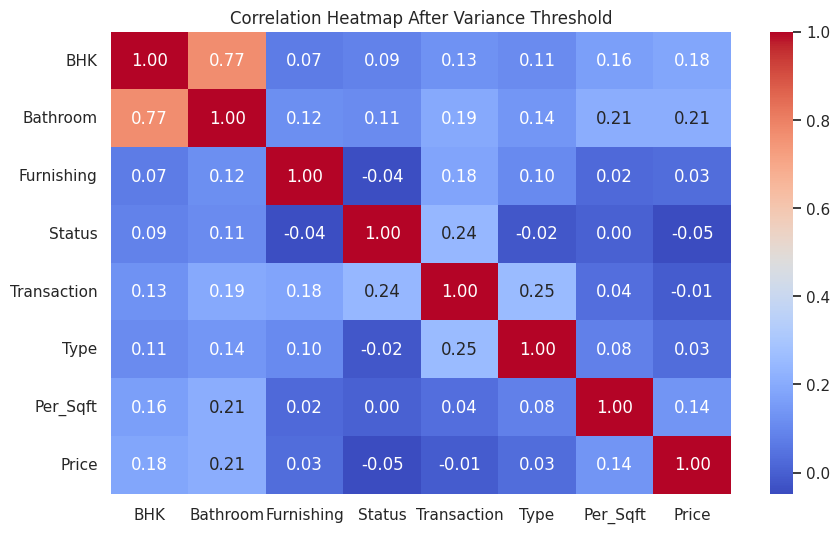

In [47]:
# Variance Threshold
if "Locality" in df.columns:
    df = df.drop(columns=["Locality"])

target = "Price"
y = df[target]
X = df.drop(columns=[target])

encoder = ce.TargetEncoder(cols=X.select_dtypes(include=['object']).columns)
X_encoded = encoder.fit_transform(X, y)

selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X_encoded)

selected_features = X_encoded.columns[selector.get_support()]

df_selected = pd.DataFrame(X_reduced, columns=selected_features)
df_selected[target] = y

df_selected.to_csv("IT24100637_Final.csv", index=False)
print("Reduced dataset saved as IT24100637_Final.csv")

corr = df_selected.corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap After Variance Threshold")
plt.show()



In [48]:
df.to_csv("final_processed.csv", index=False)

In [49]:
from google.colab import files
files.download("/content/final_processed.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>